In [24]:
import os
import sys
sys.path.append("/home/yang_liu/python_workspace/gaussian-splatting-lightning")

from matplotlib import pyplot as plt

import torch
import math
import random
from gsplat import project_gaussians
from gsplat.rasterize import rasterize_gaussians

from internal.models.gaussian_model import GaussianModel
from internal.utils.gaussian_model_loader import GaussianModelLoader
from internal.dataparsers.colmap_dataparser import ColmapParams, ColmapDataParser
from internal.dataparsers.colmap_joint_dataparser import ColmapJointDataParser

torch.set_grad_enabled(False)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [25]:
def projection_matrix(znear, zfar, fovx, fovy, device):
    """
    Constructs an OpenGL-style perspective projection matrix.
    """
    t = znear * math.tan(0.5 * fovy)
    b = -t
    r = znear * math.tan(0.5 * fovx)
    l = -r
    n = znear
    f = zfar
    return torch.tensor(
        [
            [2 * n / (r - l), 0.0, (r + l) / (r - l), 0.0],
            [0.0, 2 * n / (t - b), (t + b) / (t - b), 0.0],
            [0.0, 0.0, (f + n) / (f - n), -1.0 * f * n / (f - n)],
            [0.0, 0.0, 1.0, 0.0],
        ],
        device=device,
    )

In [26]:
# load model and dataset
model, renderer = GaussianModelLoader.search_and_load(
    "../outputs/mc_street_part_v15",
    sh_degree=3,
    device="cuda",
)
print("Gaussian count: {}".format(model.get_xyz.shape[0]))
# dataset
dataparser_outputs = ColmapJointDataParser(
    os.path.expanduser("../data/matrix_city/aerial_street_fusion/street/train"),
    os.path.abspath(""),
    global_rank=0,
    params=ColmapParams(
        eval_image_select_mode="ratio",
        eval_ratio=1.0,
    ),
).get_outputs()
print("Test camera count: {}".format(len(dataparser_outputs.test_set.cameras)))

Gaussian count: 4437829
appearance group by camera id
loading colmap 3D points
[colmap_joint dataparser] train set images: 330, val set images: 330, loaded mask: 0
Test camera count: 330


## 1. Visualize visible Gaussians

In [27]:
idx = random.randint(0, len(dataparser_outputs.test_set.cameras) - 1)
camera = dataparser_outputs.test_set.cameras[idx].to_device("cuda")
outputs = renderer(camera, model, bg_color=torch.tensor([0., 0., 0.], dtype=torch.float, device="cuda"))
image, viewspace_point_tensor, visibility_filter, radii = outputs["render"], outputs["viewspace_points"], \
                                                          outputs["visibility_filter"], outputs["radii"]

(-100.0, 400.0)

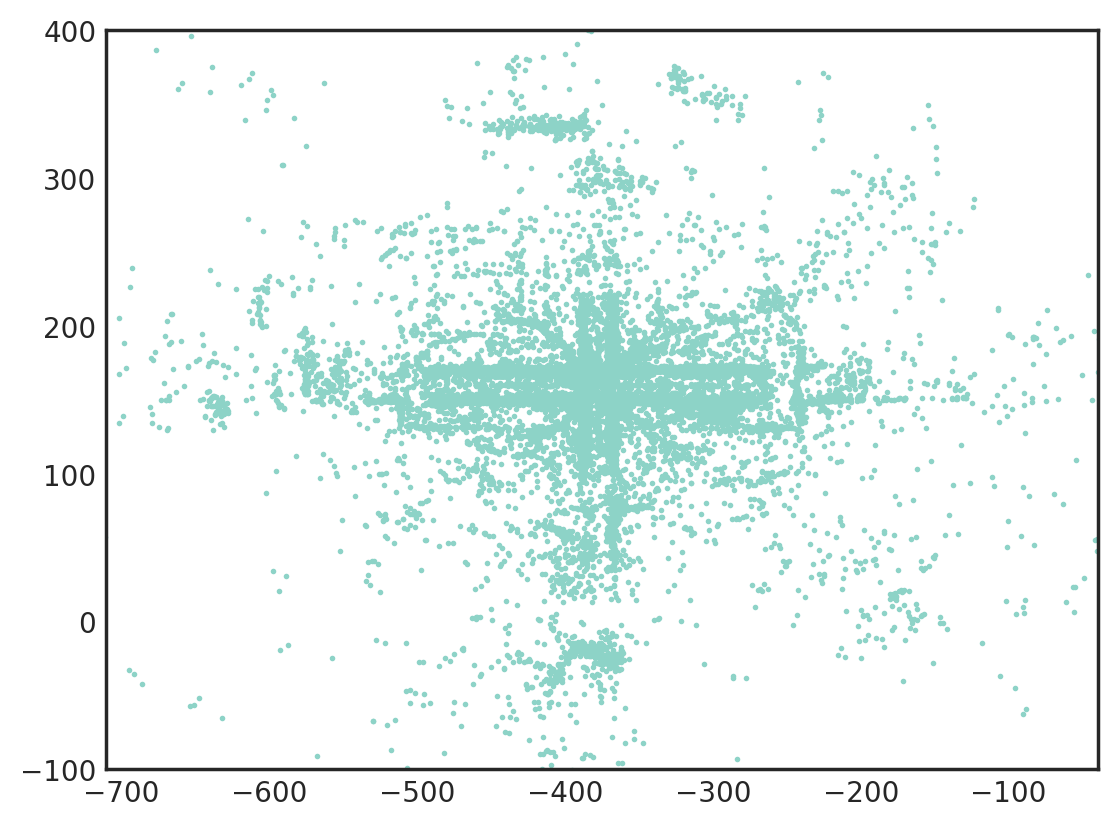

In [28]:
org_xyz = model.get_xyz
# visible_xyz = org_xyz[visibility_filter]
# cam_type = 'aerial' if camera.camera_type == 0 else 'street'

plt.style.use('seaborn-v0_8-white')
plt.figure()
plt.scatter(org_xyz[::50, 0].cpu().detach(), org_xyz[::50, 1].cpu().detach(), s=1)
# plt.scatter(visible_xyz[::50, 0].cpu().detach(), visible_xyz[::50, 1].cpu().detach(), s=1, c='r')
# plt.title(f"Visible points in {cam_type} view")
plt.axis('equal')
plt.xlim(-650, -100)
plt.ylim(-100, 400)

## 2. Collect cameras according to anchors

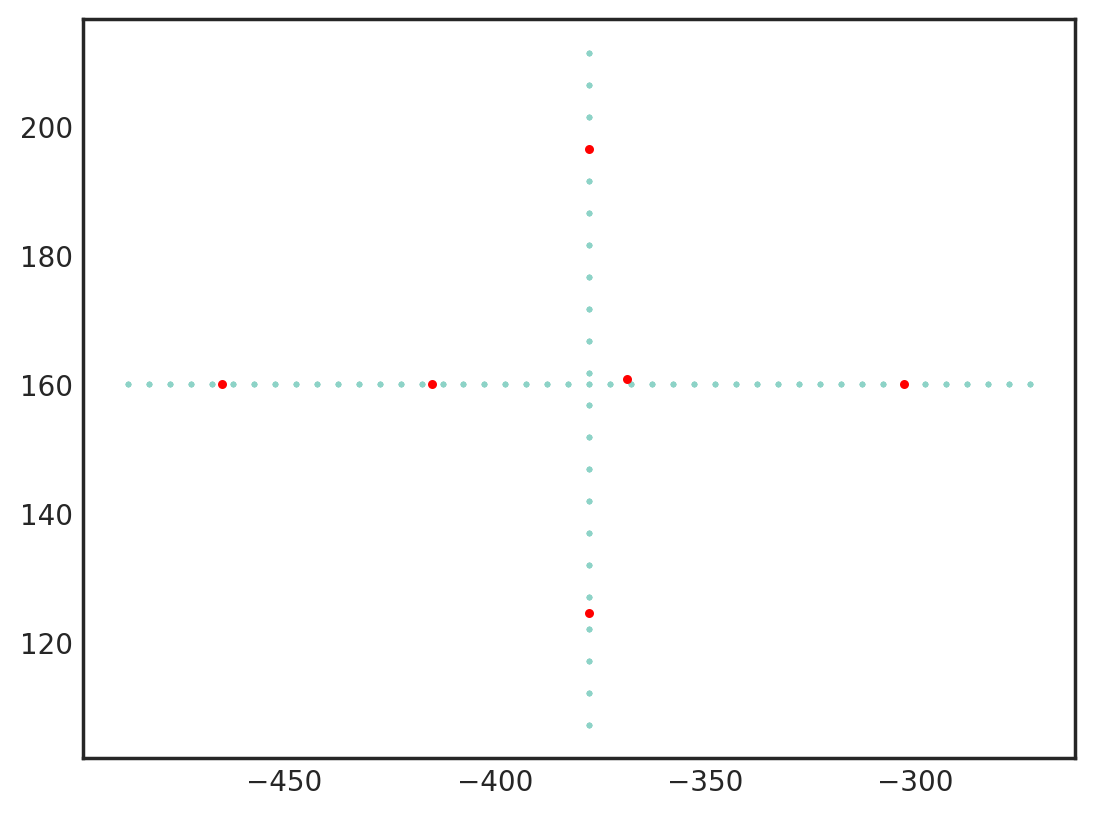

In [29]:
from sklearn.cluster import KMeans
import numpy as np

cameras = dataparser_outputs.test_set.cameras
cam_centers = []
for cam in cameras:
    cam_centers.append(cam.camera_center.cpu().numpy())

# cluster the camera centers
cam_centers = np.array(cam_centers)
kmeans = KMeans(n_clusters=6, random_state=0).fit(cam_centers)
centers = kmeans.cluster_centers_

plt.scatter(cam_centers[:, 0], cam_centers[:, 1], s=1)
plt.scatter(centers[:, 0], centers[:, 1], s=5, c='r')
plt.show()

In [31]:
anchor_size = 40 #m
vis_rate = 0.1
camera_lists = []

centers_tensor = torch.tensor(centers, dtype=torch.float, device="cuda")
org_xyz = model.get_xyz
for i in range(centers_tensor.shape[0]):
    camera_list = []
    delta = (org_xyz - centers_tensor[[i]]).abs()
    mask = (delta[:, 0] < anchor_size) & (delta[:, 1] < anchor_size) & (delta[:, 2] < anchor_size)
    if torch.sum(mask) == 0:
        continue

    num_in_anchor = torch.sum(mask)
    for camera in cameras:
        outputs = renderer(camera.to_device("cuda"), model, bg_color=torch.tensor([0., 0., 0.], dtype=torch.float, device="cuda"))
        image, viewspace_point_tensor, visibility_filter, radii = outputs["render"], outputs["viewspace_points"], \
                                                                  outputs["visibility_filter"], outputs["radii"]
        
        visible_xyz = org_xyz[visibility_filter]

        delta = (visible_xyz - centers_tensor[[i]]).abs()
        mask = (delta[:, 0] < anchor_size) & (delta[:, 1] < anchor_size) & (delta[:, 2] < anchor_size)
        if torch.sum(mask) > vis_rate * num_in_anchor:
            camera_list.append(camera)
    camera_lists.append(camera_list)
    print(f"Cameras in anchor {i}: {len(camera_list)}")


Cameras in anchor 0: 102
Cameras in anchor 1: 153
Cameras in anchor 2: 109
Cameras in anchor 3: 143
Cameras in anchor 4: 143
Cameras in anchor 5: 138
